In [74]:
from pathlib import Path
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd
import numpy as np
from IPython.display import display


phoible_data_url = "https://raw.githubusercontent.com/phoible/dev/v2.0/data/phoible.csv"
phobile_file_path = "./downloads/phoible.csv"

VALIDATE_RESULTS = True

if not Path(phobile_file_path).exists():
    response = requests.get(phoible_data_url, stream=True)

    with open(phobile_file_path, "wb") as fh:
        for data in tqdm(response.iter_content()):
            fh.write(data)

In [75]:
phoible_df = pd.read_csv(phobile_file_path, encoding="utf-8", engine="python")

In [76]:
phonemes_df = (
    phoible_df[["LanguageName", "SpecificDialect", "Phoneme"]]
    .copy()
    .fillna({"SpecificDialect": "none"})
    .drop_duplicates()
)
display(phonemes_df.head(3))
phoible_df.shape, phonemes_df.shape

,LanguageName,SpecificDialect,Phoneme
0,Korean,none,a
1,Korean,none,aː
2,Korean,none,æ


((105467, 48), (103720, 3))

In [77]:
cons_pl_tbl_df = pd.read_csv(
    "./data/consonants_plumonic.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)
display(cons_pl_tbl_df)

cons_npl_tbl_df = pd.read_csv(
    "./data/consonants_non_plumonic.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)
display(cons_npl_tbl_df)

cons_coart_tbl_df = pd.read_csv(
    "./data/consonants_coarticulated.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)
display(cons_coart_tbl_df)

vowels_tbl_df = pd.read_csv(
    "./data/vowels.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)
display(vowels_tbl_df)

all_ipa_phonemes = pd.concat(
    [
        cons_pl_tbl_df.stack(),
        cons_npl_tbl_df.stack(),
        cons_coart_tbl_df.stack(),
        vowels_tbl_df.stack(),
    ]
).replace("", np.nan).dropna().reset_index(drop=True)

print("all_ipa_phonemes", all_ipa_phonemes.shape)

cons_pl_tbl_df.shape, cons_npl_tbl_df.shape, cons_coart_tbl_df.shape, vowels_tbl_df.shape

,Bilabial,Bilabial_v,Labiodental,Labiodental_v,Dental,Dental_v,Alveolar,Alveolar_v,Postalveolar,Postalveolar_v,...,Palatal,Palatal_v,Velar,Velar_v,Uvular,Uvular_v,Pharyngeal,Pharyngeal_v,Glottal,Glottal_v
Plosive,p,b,,,t̪,d̪,t,d,,,...,c,ɟ,k,ɡ,q,ɢ,,NaN,ʔ,NaN
Nasal,,m,,ɱ,,n̪,,n,,,...,,ɲ,,ŋ,,ɴ,NaN,NaN,NaN,NaN
Trill,,ʙ,,,,r̪,,r,,,...,,,NaN,NaN,,ʀ,,,NaN,NaN
Tap or Flap,,,,ⱱ,,ɾ̪,,ɾ,,,...,,,NaN,NaN,,,,,NaN,NaN
Fricative,ɸ,β,f,v,θ,ð,s,z,ʃ,ʒ,...,ç,ʝ,x,ɣ,χ,ʁ,ħ,ʕ,h,ɦ
Lateral fricative,NaN,NaN,NaN,NaN,,,ɬ,ɮ,,,...,,,,,,,NaN,NaN,NaN,NaN
Approximant,,,,ʋ,,,,ɹ,,,...,,j,,ɰ,,,,,NaN,NaN
Lateral approximant,NaN,NaN,NaN,NaN,,l̪,,l,,,...,,ʎ,,ʟ,,,NaN,NaN,NaN,NaN


,0,1,2,3,4,5,6,7
Ejective Stop,pʼ,tʼ,ʈʼ,cʼ,kʼ,qʼ,ʡʼ,
Ejective Fricative,fʼ,θʼ,sʼ,ʃʼ,ʂʼ,ɕʼ,xʼ,χʼ
Ejective Affricate,tsʼ,t̠ʃʼ,ʈʂʼ,kxʼ,qχʼ,,,
Ejective Lateral,ɬʼ,tɬʼ,cʎ̝̊ʼ,kʟ̝̊ʼ,,,,
Click,kʘ,kǀ,kǃ,kǂ,kǁ,,,
Implosive Voiced,ɓ,ɗ,ᶑ,ʄ,ɠ,ʛ,,
Implosive Voiceless,ɓ̥,ɗ̥,ᶑ̥,ʄ̥,ɠ̊,ʛ̥,,


,Labial–alveolar,Labial–alveolar_v,Labial–retroflex,Labial–retroflex_v,Labial–palatal,Labial–palatal_v,Labial–velar,Labial–velar_v,Labial–uvular,Labial–uvular_v,Velarized alveolar,Velarized alveolar_v,Uvular–epiglottal,Uvular–epiglottal_v,Palatal-velar,Palatal-velar_v
Nasal,,n͡m,,ɳ͡m,,,,ŋ͡m,,,,,,,,
Plosive,t͡p,d͡b,ʈ͡p,ɖ͡b,,,k͡p,ɡ͡b,q͡p,,,,q͡ʡ,,,
Fricative/approximant,,,,,ɥ̊,ɥ,ʍ,w,,,,,,,ɧ,
Lateral approximant,,,,,,,,,,,,ɫ,,,,
Implosive,,,,,,,ɠ̊͜ɓ̥,ɠ͡ɓ,,,,,,,,
Ejective,,t͡pʼ,,,,,,,,,,,,,,


,Front unrounded,Front rounded,Near-front unrounded,Near-front rounded,Central unrounded,Central rounded,Near-back unrounded,Near-back rounded,Back unrounded,Back rounded
Close,i,y,,,ɨ,ʉ,,,ɯ,u
Near-close,,,ɪ,ʏ,,,,ʊ,,
Close-mid,e,ø,,,ɘ,ɵ,,,ɤ,o
Mid,e̞,ø̞,,,ə,,,,ɤ̞,o̞
Open-mid,ɛ,œ,,,ɜ,ɞ,,,ʌ,ɔ
Near-open,æ,,,ɐ,,,,,,
Open,a,ɶ,,,ä,,,,ɑ,ɒ


all_ipa_phonemes (159,)


((8, 22), (7, 8), (6, 16), (7, 10))

In [78]:
handled_phonemes = phonemes_df[phonemes_df.Phoneme.isin(all_ipa_phonemes.values)]
unhandled_phonemes = phonemes_df[~phonemes_df.Phoneme.isin(all_ipa_phonemes.values)]

display(handled_phonemes.head(3))
display(unhandled_phonemes.head(3))

handled_phonemes.shape, unhandled_phonemes.shape

,LanguageName,SpecificDialect,Phoneme
0,Korean,none,a
2,Korean,none,æ
4,Korean,none,e


,LanguageName,SpecificDialect,Phoneme
1,Korean,none,aː
3,Korean,none,æː
5,Korean,none,eː


((66711, 3), (37009, 3))

In [79]:
selected_dialects_df = (
    handled_phonemes.groupby(["LanguageName", "SpecificDialect"]).count().reset_index()
).groupby(["LanguageName"]).max().reset_index()

selected_dialects_df.head(3)

,LanguageName,SpecificDialect,Phoneme
0,!XU,none,29
1,!Xóõ,none,35
2,!Xun,W2,27


In [80]:
phonemes_to_process = handled_phonemes.merge(
    selected_dialects_df[["LanguageName", "SpecificDialect"]],
    how="inner",
    on=["LanguageName", "SpecificDialect"],
).drop(columns=["SpecificDialect"])

unique_names = np.unique(phonemes_to_process.LanguageName)


display(phonemes_to_process.head(5))
phonemes_to_process_by_language = phonemes_to_process.groupby("LanguageName")

,LanguageName,Phoneme
0,Korean,a
1,Korean,æ
2,Korean,e
3,Korean,ɤ
4,Korean,h


In [81]:
def create_symbol_matrix(phoneme_tbl_df):
    zeros = np.zeros(phoneme_tbl_df.shape).astype(np.float16)
    ones = np.ones(phoneme_tbl_df.shape).astype(np.float16)

    def map_table(dialect_df):
        phonemes = set(dialect_df.Phoneme.values)
        # this should return a matrix of shape phoneme_tbl_df.shape
        return np.where(phoneme_tbl_df.map(lambda x: x in phonemes), ones, zeros)

    return map_table


cons_pl_npy = np.stack(
    phonemes_to_process_by_language.apply(
        create_symbol_matrix(cons_pl_tbl_df), include_groups=False
    ).to_numpy()
)
cons_npl_npy = np.stack(
    phonemes_to_process_by_language.apply(
        create_symbol_matrix(cons_npl_tbl_df), include_groups=False
    ).to_numpy()
)
cons_coart_npy = np.stack(
    phonemes_to_process_by_language.apply(
        create_symbol_matrix(cons_coart_tbl_df), include_groups=False
    ).to_numpy()
)
vowels_npy = np.stack(
    phonemes_to_process_by_language.apply(
        create_symbol_matrix(vowels_tbl_df), include_groups=False
    ).to_numpy()
)


(
    cons_pl_npy.shape,
    cons_npl_npy.shape,
    cons_coart_npy.shape,
    vowels_npy.shape,
)

((2740, 8, 22), (2740, 7, 8), (2740, 6, 16), (2740, 7, 10))

In [85]:
max_cols = max(
    cons_pl_npy.shape[2],
    cons_npl_npy.shape[2],
    cons_coart_npy.shape[2],
    vowels_npy.shape[2],
)
padding_fill_value = 0.5


def get_padding(arr, rows=None, cols=None):
    row_padding = 0 if rows is None else rows - arr.shape[1]
    col_padding = 0 if cols is None else cols - arr.shape[2]
    return ((0, 0), (0, row_padding), (0, col_padding))


row2 = np.dstack(
    [
        cons_npl_npy,
        np.full((cons_npl_npy.shape[0], cons_npl_npy.shape[1], 2), padding_fill_value),
        vowels_npy,
    ]
)


language_phonemes_npy = np.hstack(
    [
        cons_pl_npy,
        np.full((cons_pl_npy.shape[0], 1, max_cols), padding_fill_value),
        np.pad(
            row2,
            get_padding(row2, cols=max_cols),
            mode="constant",
        ),
        np.full((cons_pl_npy.shape[0], 1, max_cols), padding_fill_value),
        np.pad(
            cons_coart_npy,
            get_padding(cons_coart_npy, cols=max_cols),
            mode="constant",
        ),
    ]
)

np.savez_compressed("./data/language_phonemes.npz", language_phonemes_npy)

language_phonemes_npy.shape

(2740, 23, 22)

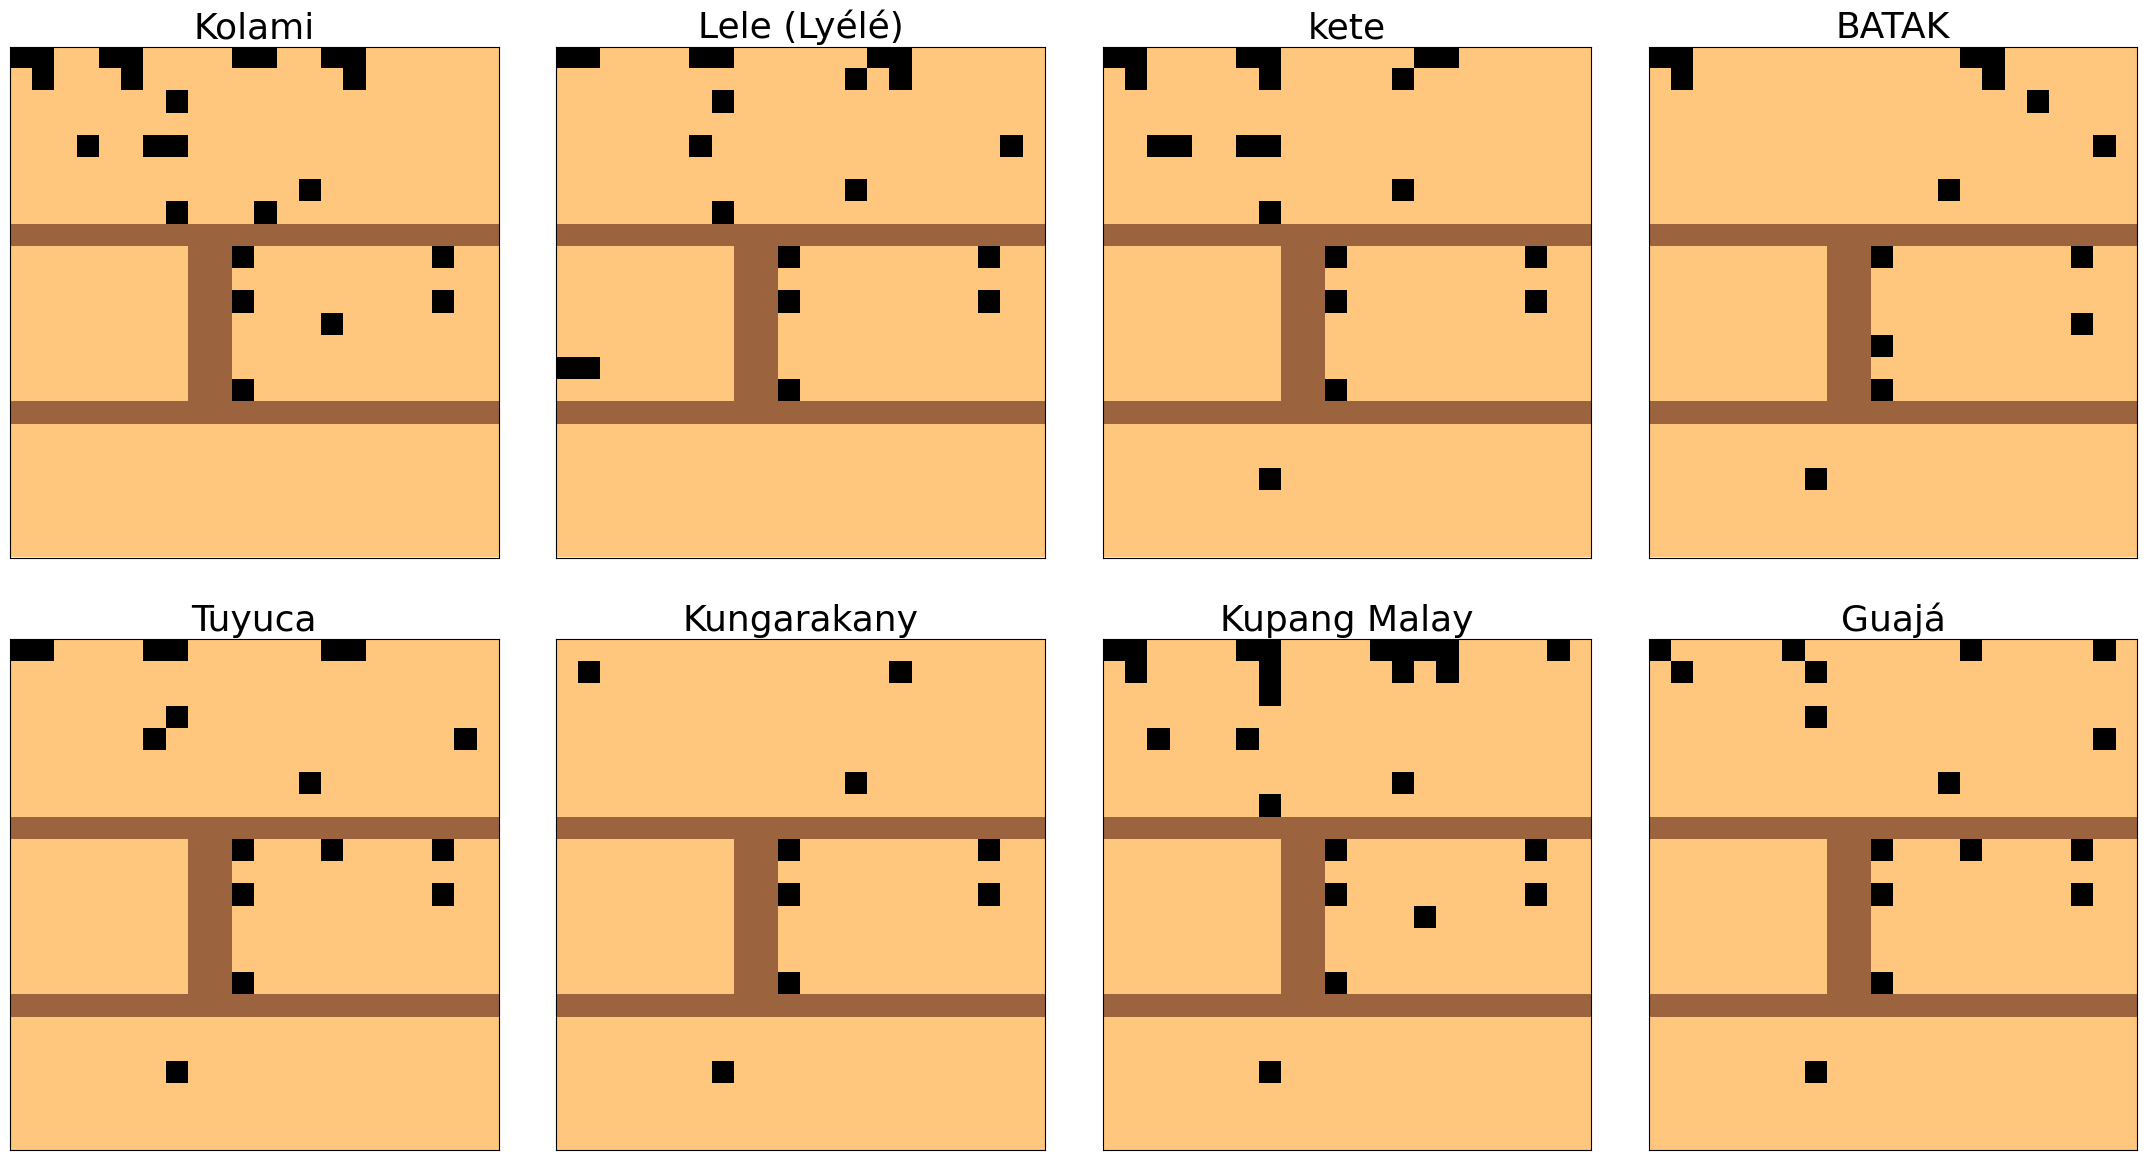

array([1127, 1262, 2613,  207, 2216, 1180, 1192,  725])

In [83]:
import matplotlib.pyplot as plt

r, c = 2, 4

gen = np.random.default_rng()
sample_indices = gen.choice(unique_names.size, r * c, replace=False)
samples = language_phonemes_npy[sample_indices]
sample_names = unique_names[sample_indices]

fig, axs = plt.subplots(r, c, figsize=(22, 12), linewidth=10)
fig.tight_layout()

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].set_title(sample_names[cnt][0:20], fontsize=26)
        axs[i, j].imshow(samples[cnt], cmap=plt.get_cmap("copper_r"))
        axs[i, j].tick_params(
            left=False, right=False, labelleft=False, labelbottom=False, bottom=False
        )
        cnt += 1

plt.show()
sample_indices

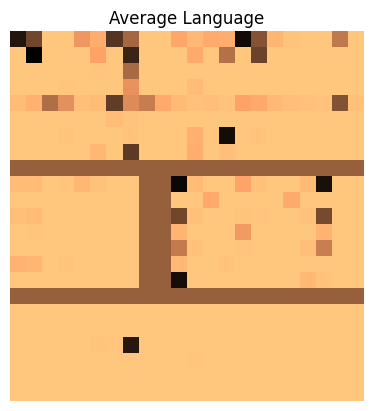

In [84]:
# what does an average language look like?
mean_lang = np.mean(language_phonemes_npy, axis=0)

fig = plt.imshow(
    mean_lang,
    cmap=plt.get_cmap("copper_r"),
    vmin=np.min(mean_lang),
    vmax=np.max(mean_lang),
)
plt.axis("off")
plt.title("Average Language")
plt.show()